Kod nie kompletny - prostszy ale brakuje liczenia błedu w sposób taki jak jest w przykładzie/

Device: cpu


Epoka 1/3: 100%|██████████| 782/782 [11:02<00:00,  1.18it/s]


Epoka 1: loss=0.2679, lr=0.00150


Epoka 2/3: 100%|██████████| 782/782 [10:47<00:00,  1.21it/s]


Epoka 2: loss=0.1897, lr=0.00050


Epoka 3/3: 100%|██████████| 782/782 [10:32<00:00,  1.24it/s]


Epoka 3: loss=0.1693, lr=0.00000


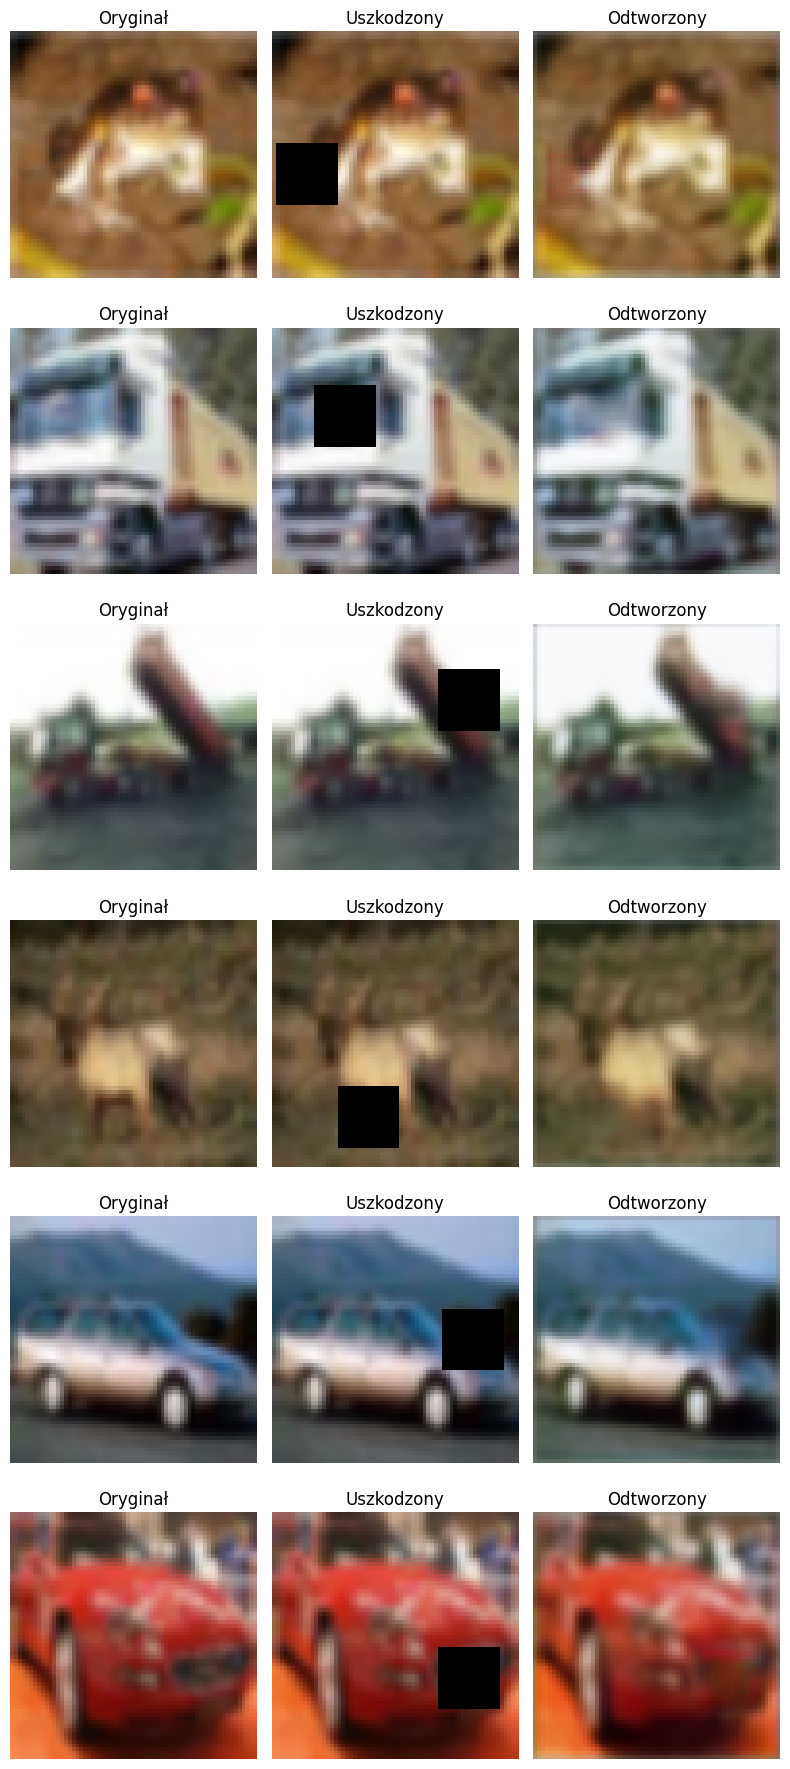

K-Means…
Gotowe.


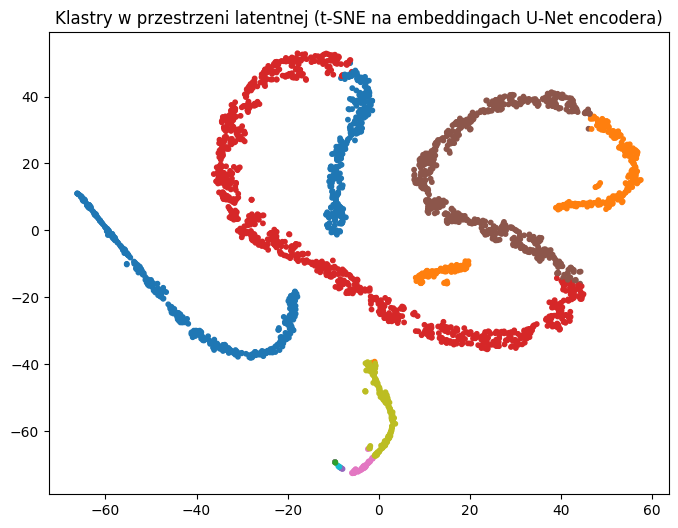

In [6]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch_msssim import ssim as ssim_fn  # pip install pytorch-msssim
import math, random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ======= CONFIG =======
batch_size = 64
in_size    = 64     # podbijamy CIFAR (32->64) dla lepszej jakości
latent_dim = 128
num_clusters = 10
epochs = 3
mask_square_ratio = 1/16  # zgodnie z wymaganiami (<=1/16)
use_freeform_masks = True

# ======= DATA =======
transform = transforms.Compose([
    transforms.Resize((in_size, in_size)),
    transforms.ToTensor(),
])
train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# ======= MASKS =======
def square_mask(h, w, ratio=mask_square_ratio):
    m = torch.zeros((1, h, w))
    s = int(math.sqrt(ratio) * h)
    y = random.randint(0, h - s)
    x = random.randint(0, w - s)
    m[:, y:y+s, x:x+s] = 1.0
    return m

def freeform_mask(h, w, max_brush=4, max_len=12, max_vertices=8):
    """Prosta nieregularna maska pędzlem (free-form)"""
    m = torch.zeros((1, h, w))
    num_v = random.randint(1, max_vertices)
    for _ in range(num_v):
        x, y = random.randint(0, w-1), random.randint(0, h-1)
        for _ in range(random.randint(1, max_len)):
            angle = random.uniform(0, 2*math.pi)
            length = random.randint(4, 12)
            brush = random.randint(2, max_brush)
            x2 = np.clip(int(x + length * math.cos(angle)), 0, w-1)
            y2 = np.clip(int(y + length * math.sin(angle)), 0, h-1)
            m[:, min(y,y2):max(y,y2)+brush, min(x,x2):max(x,x2)+brush] = 1.0
            x, y = x2, y2
    # przycinamy do maks. udziału ~1/16-1/8, żeby nie przesadzić
    if m.mean() > 0.2:
        m = (m > m.quantile(0.8)).float()
    return m

def make_mask(h, w):
    m = square_mask(h, w)
    if use_freeform_masks and random.random() < 0.5:
        m = torch.maximum(m, freeform_mask(h, w))
    return m.clamp(0,1)

# ======= U-Net (lekki) =======
def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.ReLU(inplace=True)
    )

class UNetSmall(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.enc1 = conv_block(3, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 128)

        self.up3 = nn.ConvTranspose2d(128, 128, 2, 2)
        self.dec3 = conv_block(128+128, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = conv_block(64+64, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = conv_block(32+32, 32)

        self.out = nn.Conv2d(32, 3, 1)

        # prosta głowa do embeddingu (E) – global average pooling + linear
        self.embed_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        e1 = self.enc1(x)           # [B,32,H,W]
        p1 = self.pool1(e1)         # [B,32,H/2,W/2]
        e2 = self.enc2(p1)          # [B,64,H/2,W/2]
        p2 = self.pool2(e2)         # [B,64,H/4,W/4]
        e3 = self.enc3(p2)          # [B,128,H/4,W/4]
        p3 = self.pool3(e3)         # [B,128,H/8,W/8]

        b  = self.bottleneck(p3)    # [B,128,H/8,W/8]

        z  = self.embed_head(b)     # embedding do K-means

        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = torch.sigmoid(self.out(d1))
        return out, z

model = UNetSmall(latent_dim).to(device)

# ======= Mask-aware loss (L1 + SSIM tylko na masce) =======
def masked_l1(pred, target, mask):
    # mask: 1 tam, gdzie brak (liczymy stratę), 0 gdzie znane (ignorujemy)
    eps = 1e-6
    denom = mask.sum(dim=(1,2,3)) + eps
    l1 = (torch.abs(pred - target) * mask).sum(dim=(1,2,3)) / denom
    return l1.mean()

def masked_ssim(pred, target, mask):
    # liczymy SSIM na całym obrazie, ale ważymy maską
    s = ssim_fn(pred, target, data_range=1.0, size_average=False)
    # ssim to „im większe tym lepiej”, więc strata = 1-ssim
    # ważymy przez udział maski (tam gdzie coś rekonstruujemy)
    w = (mask.mean(dim=(1,2,3)) + 1e-6)
    loss = (1 - s) * w
    return loss.mean()

# ======= Optymalizacja =======
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# ======= Trening =======
model.train()
for ep in range(epochs):
    running = 0.0
    for x, _ in tqdm(train_loader, desc=f"Epoka {ep+1}/{epochs}"):
        x = x.to(device)
        # maska i obraz wejściowy z „dziurą”
        m = torch.stack([make_mask(in_size, in_size) for _ in range(x.size(0))]).to(device)  # [B,1,H,W]
        x_masked = x * (1 - m)

        y_pred, _ = model(x_masked)

        # L = L1_masked + 0.5 * SSIM_masked
        l1 = masked_l1(y_pred, x, m)
        lssim = masked_ssim(y_pred, x, m)
        loss = l1 + 0.5 * lssim

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item()
    scheduler.step()
    print(f"Epoka {ep+1}: loss={running/len(train_loader):.4f}, lr={scheduler.get_last_lr()[0]:.5f}")

# ======= Inpainting – podgląd =======
def show_results(n=5):
    model.eval()
    imgs = [train_ds[i][0] for i in range(n)]
    msks = [make_mask(in_size, in_size) for _ in range(n)]
    x = torch.stack(imgs).to(device)
    m = torch.stack(msks).to(device)
    with torch.no_grad():
        x_in = x * (1 - m)
        y, _ = model(x_in)
    fig, axes = plt.subplots(n, 3, figsize=(8, 3*n))
    for i in range(n):
        axes[i,0].imshow(np.transpose(imgs[i].numpy(), (1,2,0))); axes[i,0].set_title("Oryginał");   axes[i,0].axis("off")
        axes[i,1].imshow(np.transpose((x_in[i].cpu().numpy()), (1,2,0))); axes[i,1].set_title("Uszkodzony"); axes[i,1].axis("off")
        axes[i,2].imshow(np.transpose((y[i].cpu().numpy()), (1,2,0))); axes[i,2].set_title("Odtworzony"); axes[i,2].axis("off")
    plt.tight_layout(); plt.show()

show_results(n=6)

# ======= Embeddingi z encodera i klasteryzacja =======
model.eval()
embs = []
with torch.no_grad():
    for x, _ in DataLoader(train_ds, batch_size=batch_size):
        x = x.to(device)
        x_masked = x  # do embeddingu możemy podać pełny obraz; to nienadzorowane
        _, z = model(x_masked)
        z = nn.functional.normalize(z, dim=1)  # L2-norm → stabilniejsze k-means
        embs.append(z.cpu().numpy())
embs = np.concatenate(embs, axis=0)

print("K-Means…")
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
labels = kmeans.fit_predict(embs)
print("Gotowe.")

# ======= Wizualizacja klastrów (UMAP jeśli masz, w przeciwnym razie t-SNE) =======
from sklearn.manifold import TSNE
idx = np.random.choice(len(embs), size=min(3000, len(embs)), replace=False)
E2 = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto").fit_transform(embs[idx])

plt.figure(figsize=(8,6))
plt.scatter(E2[:,0], E2[:,1], c=labels[idx], s=10, cmap="tab10")
plt.title("Klastry w przestrzeni latentnej (t-SNE na embeddingach U-Net encodera)")
plt.show()


Projekt bardziej zgodny ze schematem

Urządzenie: cpu


Epoka 1/1 (pretrain): 100%|██████████| 704/704 [10:59<00:00,  1.07it/s]


[PRE] epoka 1: L_A=0.2731, lr=0.00000


[DC 1] fine-tune 1/1: 100%|██████████| 704/704 [09:41<00:00,  1.21it/s]


[DC 1] epoka 1: L_total=1.9157


[DC 2] fine-tune 1/1: 100%|██████████| 704/704 [09:26<00:00,  1.24it/s]


[DC 2] epoka 1: L_total=1.1042


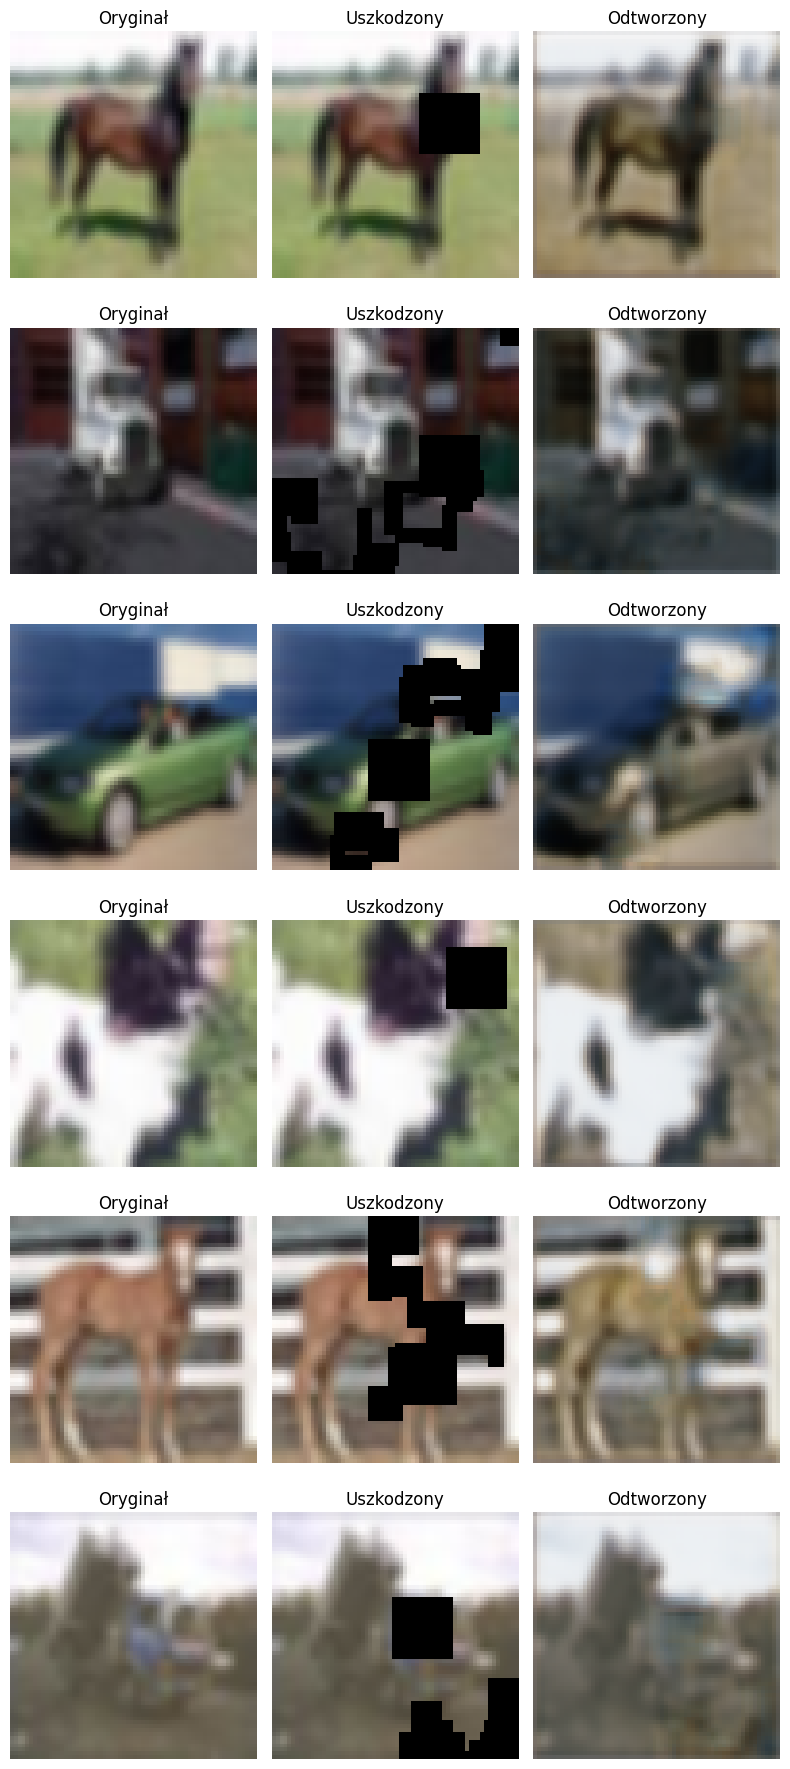

K-means (final na train)…
Gotowe.


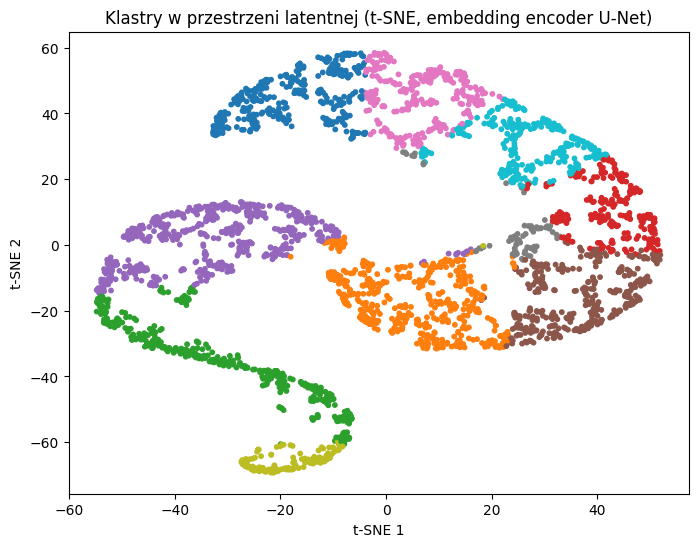

In [1]:
# ==========================================
# PROJEKT: Nienadzorowane uzupełnianie obrazów + Deep Clustering
# DANE: CIFAR-10 (tu tylko jako nośnik; docelowo WikiArt)
# SCHEMAT: E (encoder) → K (klasteryzacja) → D (decoder/inpainting)
# STRATY:  L_A (mask-aware), L_C (klastrowa), L_B (balans klastrów)
# ==========================================

import math, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm
from pytorch_msssim import ssim as ssim_fn  # pip install pytorch-msssim


# ================================
# 0) USTAWIENIA
# ================================
urzadzenie       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Urządzenie:", urzadzenie)

if urzadzenie.type == "cuda":
    torch.backends.cudnn.benchmark = True  # przyspieszenie konwolucji

rozmiar_paczki   = 64
rozmiar_wejscia  = 64      # CIFAR 32→64 (więcej piksli do inpaintingu)
wymiar_latentu   = 128
liczba_klastrow  = 10
epoki_pretrain   = 1       # pre-training inpaintingu (L_A)

# DeepCluster (pętle L_C + L_B)
rundy_dc         = 2
epoki_dc         = 1 
lambda_c         = 1.0     # waga L_C
lambda_b         = 0.1     # waga L_B

# maski
udzial_kwadratu  = 1/16    # wymóg: ≤ 1/16 obrazu
uzywaj_freeform  = True    # rozszerzenie: nieregularne „pędzlem”


# ================================
# 1) DANE (train / val / test)
# ================================
transformacje = transforms.Compose([
    transforms.Resize((rozmiar_wejscia, rozmiar_wejscia)),
    transforms.ToTensor(),
])

caly_train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transformacje)
test_zbior = datasets.CIFAR10(root="./data", train=False, download=True, transform=transformacje)

wielkosc_val = 5000
wielkosc_train = len(caly_train) - wielkosc_val
train_zbior, val_zbior = random_split(
    caly_train, [wielkosc_train, wielkosc_val],
    generator=torch.Generator().manual_seed(42)
)

pin = (urzadzenie.type == "cuda")

# Loadery (num_workers=0 — stabilnie na Windows)
loader_train = DataLoader(train_zbior, batch_size=rozmiar_paczki,
                          shuffle=True,  num_workers=0, pin_memory=pin)
loader_val   = DataLoader(val_zbior,   batch_size=rozmiar_paczki,
                          shuffle=False, num_workers=0, pin_memory=pin)
loader_test  = DataLoader(test_zbior,  batch_size=rozmiar_paczki,
                          shuffle=False, num_workers=0, pin_memory=pin)

# Loader „bez tasowania” z indeksami GLOBALNYMI (do pseudolabelek k-means)
class PodzbiorZIndeksami(Dataset):
    def __init__(self, subset):            # subset: torch.utils.data.Subset (train_zbior)
        self.subset  = subset
        self.indeksy = subset.indices      # mapuje indeks lokalny -> globalny w caly_train
    def __len__(self): return len(self.subset)
    def __getitem__(self, i):
        x, _ = self.subset[i]
        idx_globalny = self.indeksy[i]
        return x, idx_globalny

loader_train_bez_shuffle = DataLoader(
    PodzbiorZIndeksami(train_zbior),
    batch_size=rozmiar_paczki, shuffle=False, num_workers=0, pin_memory=pin
)


# ================================
# 2) GENERATOR MASEK (kwadrat ≤1/16 + free-form)
# ================================
def maska_kwadrat(h, w, ratio=udzial_kwadratu):
    m = torch.zeros((1, h, w))
    s = int(math.sqrt(ratio) * h)
    y = random.randint(0, h - s)
    x = random.randint(0, w - s)
    m[:, y:y+s, x:x+s] = 1.0
    return m

def maska_freeform(h, w, max_brush=4, max_len=12, max_vertices=8):
    m = torch.zeros((1, h, w))
    v = random.randint(1, max_vertices)
    for _ in range(v):
        x, y = random.randint(0, w-1), random.randint(0, h-1)
        for _ in range(random.randint(1, max_len)):
            kat    = random.uniform(0, 2*math.pi)
            dl     = random.randint(4, 12)
            pedzel = random.randint(2, max_brush)
            x2 = np.clip(int(x + dl * math.cos(kat)), 0, w-1)
            y2 = np.clip(int(y + dl * math.sin(kat)), 0, h-1)
            m[:, min(y,y2):max(y,y2)+pedzel, min(x,x2):max(x,x2)+pedzel] = 1.0
            x, y = x2, y2
    # przytnij, jeśli zbyt duża
    if m.mean() > 0.2:
        m = (m > m.quantile(0.8)).float()
    return m

def losowa_maska(h, w):
    m = maska_kwadrat(h, w)
    if uzywaj_freeform and random.random() < 0.5:
        m = torch.maximum(m, maska_freeform(h, w))
    return m.clamp(0, 1)


# ================================
# 3) MODEL: lekki U-Net + głowa embeddingu
# ================================
def blok_konw(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.ReLU(inplace=True)
    )

class UNetMaly(nn.Module):
    def __init__(self, dim_latentu=128):
        super().__init__()
        self.enc1  = blok_konw(3, 32);  self.pool1 = nn.MaxPool2d(2)
        self.enc2  = blok_konw(32, 64); self.pool2 = nn.MaxPool2d(2)
        self.enc3  = blok_konw(64, 128);self.pool3 = nn.MaxPool2d(2)

        self.bott  = blok_konw(128, 128)

        self.up3   = nn.ConvTranspose2d(128, 128, 2, 2)
        self.dec3  = blok_konw(128+128, 128)
        self.up2   = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2  = blok_konw(64+64, 64)
        self.up1   = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1  = blok_konw(32+32, 32)

        self.wyjscie = nn.Conv2d(32, 3, 1)

        # głowa embeddingu (E)
        self.head_z = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, dim_latentu)
        )

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)

        b  = self.bott(p3)
        z  = self.head_z(b)  # embedding (E)

        u3 = self.up3(b); d3 = self.dec3(torch.cat([u3, e3], dim=1))
        u2 = self.up2(d3); d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, e1], dim=1))

        y  = torch.sigmoid(self.wyjscie(d1))  # rekonstrukcja (D)
        return y, z

model = UNetMaly(wymiar_latentu).to(urzadzenie)


# ================================
# 4) STRATY: L_A (mask-aware), L_C, L_B
# ================================
def l1_maskowane(pred, target, mask):
    eps = 1e-6
    mian = mask.sum(dim=(1,2,3)) + eps
    l1   = (torch.abs(pred - target) * mask).sum(dim=(1,2,3)) / mian
    return l1.mean()

def ssim_maskowane(pred, target, mask):
    s = ssim_fn(pred, target, data_range=1.0, size_average=False)  # większe = lepiej
    w = (mask.mean(dim=(1,2,3)) + 1e-6)                            # ważenie udziałem maski
    return ((1 - s) * w).mean()                                    # mniejsze = lepiej

def strata_balansu(probs, k):
    """L_B: zbalansuj klastry (średni rozkład ~ 1/K)"""
    p_mean = probs.mean(dim=0)                     # [K]
    target = torch.full_like(p_mean, 1.0/k)
    return ((p_mean - target) ** 2).sum()


# ================================
# 5) PRE-TRAIN: uczymy inpainting (L_A)
# ================================
opt_pre = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
sched   = optim.lr_scheduler.CosineAnnealingLR(opt_pre, T_max=epoki_pretrain)

model.train()
for ep in range(epoki_pretrain):
    suma = 0.0
    for obrazy, _ in tqdm(loader_train, desc=f"Epoka {ep+1}/{epoki_pretrain} (pretrain)"):
        obrazy = obrazy.to(urzadzenie)
        maski  = torch.stack([losowa_maska(rozmiar_wejscia, rozmiar_wejscia) for _ in range(obrazy.size(0))]).to(urzadzenie)
        uszkodzone = obrazy * (1 - maski)

        y_hat, _ = model(uszkodzone)

        la  = l1_maskowane(y_hat, obrazy, maski) + 0.5 * ssim_maskowane(y_hat, obrazy, maski)
        opt_pre.zero_grad(); la.backward(); opt_pre.step()
        suma += la.item()
    sched.step()
    print(f"[PRE] epoka {ep+1}: L_A={suma/len(loader_train):.4f}, lr={sched.get_last_lr()[0]:.5f}")


# ================================
# 6) DEEP-CLUSTER: L_C + L_B (+ fine-tune E)
# ================================
glowica_klastra = nn.Linear(wymiar_latentu, liczba_klastrow).to(urzadzenie)
opt_dc = optim.Adam(list(model.parameters()) + list(glowica_klastra.parameters()), lr=1e-3)
ce = nn.CrossEntropyLoss()

for runda in range(rundy_dc):
    # 6.1) Ekstrakcja embeddingów + ZAPIS globalnych indeksów w tej samej kolejności
    model.eval()
    wszystkie_z = []
    kolejnosc_global = []  # <<--- NOWE
    with torch.no_grad():
        for xb, idx_global in tqdm(loader_train_bez_shuffle, desc=f"[DC {runda+1}/{rundy_dc}] ekstrakcja Z"):
            xb = xb.to(urzadzenie)
            _, z = model(xb)
            z = nn.functional.normalize(z, dim=1)
            wszystkie_z.append(z.cpu().numpy())
            kolejnosc_global.append(idx_global.numpy())  # <<--- zapisz porządek globalnych indeksów
    wszystkie_z = np.concatenate(wszystkie_z, axis=0)              # [N_train, dim]
    kolejnosc_global = np.concatenate(kolejnosc_global, axis=0)    # [N_train], wartości 0..49999

    # 6.2) K-means → pseudolabelki W TEJ SAMEJ KOLEJNOŚCI co kolejnosc_global
    km = KMeans(n_clusters=liczba_klastrow, n_init=10, random_state=42)
    pseudo_train = km.fit_predict(wszystkie_z)   # [N_train], indexowane po kolejnosc_global

    # 6.2b) Zbuduj tablicę pseudolabelek po GLOBALNYCH indeksach (wielkości całego caly_train)
    pseudo_po_global = np.full(len(caly_train), -1, dtype=np.int64)   # init -1 dla nie-train
    pseudo_po_global[kolejnosc_global] = pseudo_train                  # przypisz tylko train

    # 6.3) Fine-tune: L = L_A + λc*L_C + λb*L_B (na TRAIN bez shuffle)
    model.train()
    for ep in range(epoki_dc):
        suma = 0.0
        for xb, idx_global in tqdm(loader_train_bez_shuffle, desc=f"[DC {runda+1}] fine-tune {ep+1}/{epoki_dc}"):
            xb  = xb.to(urzadzenie)
            msk = torch.stack([losowa_maska(rozmiar_wejscia, rozmiar_wejscia) for _ in range(xb.size(0))]).to(urzadzenie)
            x_in = xb * (1 - msk)

            y_hat, z = model(x_in)
            logity   = glowica_klastra(z)
            prawd    = logity.softmax(dim=1)

            # >>> kluczowa zmiana: pobieramy pseudolabelki po GLOBALNYCH indeksach
            y_pseudo_np = pseudo_po_global[idx_global.numpy()]          # [B], wartości 0..K-1
            y_pseudo = torch.from_numpy(y_pseudo_np).to(urzadzenie)

            lc = ce(logity, y_pseudo)                     # L_C
            lb = strata_balansu(prawd, liczba_klastrow)   # L_B
            la = l1_maskowane(y_hat, xb, msk) + 0.5 * ssim_maskowane(y_hat, xb, msk)

            strata = la + lambda_c * lc + lambda_b * lb
            opt_dc.zero_grad(); strata.backward(); opt_dc.step()
            suma += strata.item()
        print(f"[DC {runda+1}] epoka {ep+1}: L_total={suma/len(loader_train_bez_shuffle):.4f}")

# ================================
# 7) PODGLĄD INPAINTINGU (na walidacji – bez „leaka”)
# ================================
def pokaz_inpainting(n=6):
    model.eval()
    obrazy = [val_zbior[i][0] for i in range(n)]
    maski  = [losowa_maska(rozmiar_wejscia, rozmiar_wejscia) for _ in range(n)]
    x  = torch.stack(obrazy).to(urzadzenie)
    m  = torch.stack(maski).to(urzadzenie)
    with torch.no_grad():
        x_in = x * (1 - m)
        y, _ = model(x_in)
    fig, ax = plt.subplots(n, 3, figsize=(8, 3*n))
    for i in range(n):
        ax[i,0].imshow(np.transpose(obrazy[i].numpy(), (1,2,0)));       ax[i,0].set_title("Oryginał");   ax[i,0].axis("off")
        ax[i,1].imshow(np.transpose(x_in[i].cpu().numpy(), (1,2,0)));   ax[i,1].set_title("Uszkodzony"); ax[i,1].axis("off")
        ax[i,2].imshow(np.transpose(y[i].cpu().numpy(), (1,2,0)));      ax[i,2].set_title("Odtworzony"); ax[i,2].axis("off")
    plt.tight_layout(); plt.show()

pokaz_inpainting(n=6)


# ================================
# 8) OSTATECZNA KLASTERYZACJA + WIZUALIZACJA (na TRAIN)
# ================================
model.eval()
emb_train = []
with torch.no_grad():
    for xb, _ in DataLoader(train_zbior, batch_size=rozmiar_paczki, shuffle=False, num_workers=0, pin_memory=pin):
        xb = xb.to(urzadzenie)
        _, z = model(xb)
        z = nn.functional.normalize(z, dim=1)
        emb_train.append(z.cpu().numpy())
emb_train = np.concatenate(emb_train, axis=0)

print("K-means (final na train)…")
kmeans_final = KMeans(n_clusters=liczba_klastrow, n_init=10, random_state=42)
etykiety = kmeans_final.fit_predict(emb_train)
print("Gotowe.")

# rzut 2D (t-SNE) – szybka podglądówka
idx = np.random.choice(len(emb_train), size=min(3000, len(emb_train)), replace=False)
E2 = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto").fit_transform(emb_train[idx])

plt.figure(figsize=(8,6))
plt.scatter(E2[:,0], E2[:,1], c=etykiety[idx], s=10, cmap="tab10")
plt.title("Klastry w przestrzeni latentnej (t-SNE, embedding encoder U-Net)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()


które między innymi epoki powienem zwiększyć do już lepszego sprawdzenia modelu ?

Pełna zgodność modelu z projektem i wymaganiami